# LOAD DATA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

import yfinance as yf
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
# Download Stock Data
ticker_symbol = "^GSPC"
data = yf.download(tickers=[ticker_symbol,"^VIX"], start="2023-01-01", end="2025-09-01")

/tmp/ipython-input-2316725938.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers=[ticker_symbol,"^VIX"], start="2023-01-01", end="2025-09-01")
[*********************100%***********************]  2 of 2 completed


In [3]:
# Extract the close price
close = data["Close"]
display(close)

Ticker            ^GSPC       ^VIX
Date                              
2023-01-03  3824.139893  22.900000
2023-01-04  3852.969971  22.010000
2023-01-05  3808.100098  22.459999
2023-01-06  3895.080078  21.129999
2023-01-09  3892.090088  21.969999
...                 ...        ...
2025-08-25  6439.319824  14.790000
2025-08-26  6465.939941  14.620000
2025-08-27  6481.399902  14.850000
2025-08-28  6501.859863  14.430000
2025-08-29  6460.259766  15.360000

[667 rows x 2 columns]

# PROCESSING DATA FOR RIDGE

In [4]:
# Create 5 days SMA and 20 days SMA for both ticker and VIX Index
sp_features = pd.DataFrame({
    "sp_sma5": close[ticker_symbol].rolling(5).mean().shift(1),
    "sp_sma20": close[ticker_symbol].rolling(20).mean().shift(1)
})
vix_features = pd.DataFrame({
    "vix_sma5": close["^VIX"].rolling(5).mean().shift(1),
    "vix_sma20": close["^VIX"].rolling(20).mean().shift(1)
})
# Combine the processed features
features = pd.concat([sp_features, vix_features], axis=1).dropna()
target = close[ticker_symbol].loc[features.index]
# Scale X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)
y = target.values

In [5]:
split_ratio = 0.8
split_index = int(len(X_scaled) * split_ratio)

X_train = X_scaled[:split_index]
y_train = y[:split_index]

X_test = X_scaled[split_index:]
y_test = y[split_index:]

# RIDGE MODEL

In [6]:


# Train
model_1 = Ridge(solver="svd",alpha=1,random_state=69)
model_1.fit(X_train, y_train)

# Predict
y_pred = model_1.predict(X_test)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Test RMSE:", rmse)
print("Test R^2:", r2)
print("Test MAE:", mae)


Test RMSE: 113.27810579509816
Test R^2: 0.9053585868053156
Test MAE: 77.32779799943857


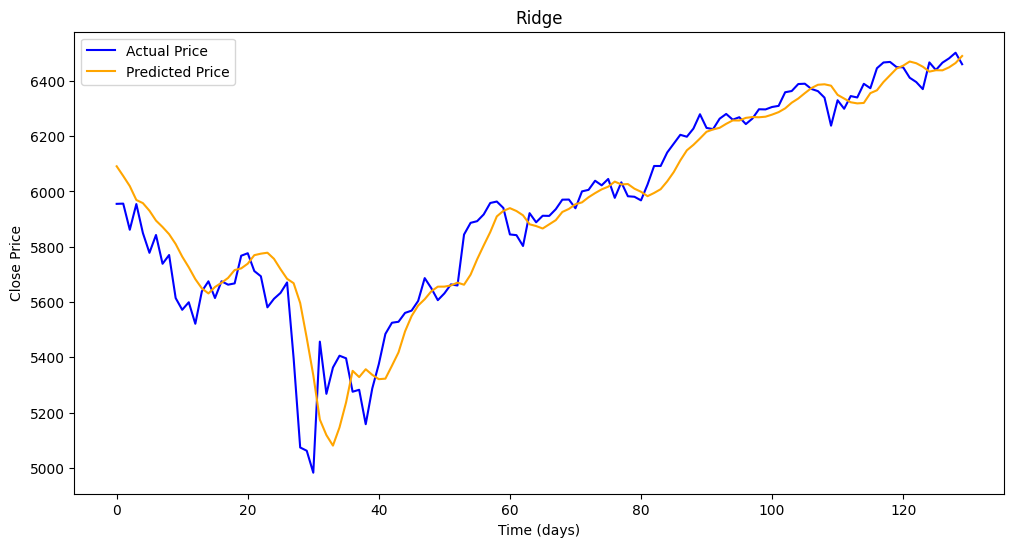

In [7]:
# Plot the prediction vs actual
plt.figure(figsize=(12,6))
plt.plot(y_test, label="Actual Price", color="blue")
plt.plot(y_pred, label="Predicted Price", color="orange")
plt.title("Ridge")
plt.xlabel("Time (days)")
plt.ylabel("Close Price")
plt.legend()
plt.show()


# DATA PROCESSING FOR LSTM

In [8]:
# Parameters
lookback = 20   # number of past days per sample
n_splits = 3    # walk-forward folds


In [9]:
X, y = [], []

for i in range(lookback, len(close)):
    X.append(close.iloc[i-lookback:i].values)  # sequence of 'lookback' days, all features
    y.append(close.iloc[i]['^GSPC'])          # next day's SP500 close

X = np.array(X)  # shape: (samples, lookback, features)
y = np.array(y)  # shape: (samples,)


In [10]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

num_samples, timesteps, num_features = X.shape

# Flatten for scaler
X_flat = X.reshape(-1, num_features)
X_scaled_flat = scaler_X.fit_transform(X_flat)
X_scaled = X_scaled_flat.reshape(num_samples, timesteps, num_features)

y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# LSTM MODEL

In [11]:
tscv = TimeSeriesSplit(n_splits=n_splits)

rmse_scores, mae_scores, r2_scores = [], [], []
all_preds = np.full_like(y_scaled, fill_value=np.nan, dtype=float)

fold = 1
for train_idx, val_idx in tscv.split(X_scaled):
    print(f"\n===== Fold {fold} =====")

    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_train, y_val = y_scaled[train_idx], y_scaled[val_idx]

    # Build model
    model_2 = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(50, activation="tanh"),
        Dense(1)
    ])
    model_2.compile(optimizer="adam", loss="mse")

    # Early stopping
    es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

    # Train
    history = model_2.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=16,
        verbose=0,
        callbacks=[es]
    )

    # Predict
    y_val_pred_scaled = model_2.predict(X_val, verbose=0)
    y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled)
    y_val_true = scaler_y.inverse_transform(y_val)

    # Save fold predictions
    all_preds[val_idx] = y_val_pred

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_val_true, y_val_pred))
    mae = mean_absolute_error(y_val_true, y_val_pred)
    r2  = r2_score(y_val_true, y_val_pred)

    print(f"Fold {fold} RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.3f}")

    rmse_scores.append(rmse)
    mae_scores.append(mae)
    r2_scores.append(r2)

    fold += 1



===== Fold 1 =====
Fold 1 RMSE: 139.46, MAE: 120.83, R²: 0.828

===== Fold 2 =====
Fold 2 RMSE: 91.11, MAE: 69.45, R²: 0.860

===== Fold 3 =====


Fold 3 RMSE: 103.54, MAE: 74.34, R²: 0.904


Average RMSE: 111.36820048534658
Average MAE : 88.2087650022645
Average R²  : 0.864203182425047


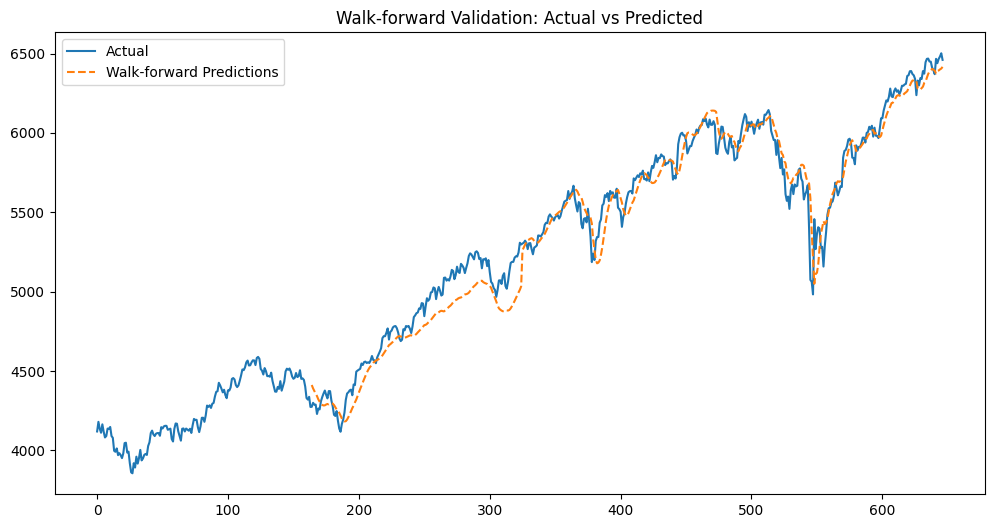

In [12]:
print("Average RMSE:", np.mean(rmse_scores))
print("Average MAE :", np.mean(mae_scores))
print("Average R²  :", np.mean(r2_scores))

# Plot actual vs walk-forward predictions
y_all_true = scaler_y.inverse_transform(y_scaled)

plt.figure(figsize=(12,6))
plt.plot(y_all_true, label="Actual")
plt.plot(all_preds, label="Walk-forward Predictions", linestyle="--")
plt.legend()
plt.title("Walk-forward Validation: Actual vs Predicted")
plt.show()

# Future Prediction

In [13]:
"""Single Day Future Prediction for Ridge and LSTM Models"""
# ============================================================================
# PREDICT NEXT TRADING DAY
# ============================================================================

print("\n" + "="*60)
print("PREDICTING NEXT TRADING DAY")
print("="*60)

# Get the last date in the dataset
last_date = close.index[-1]

# Calculate next trading date (skip weekends)
next_date = last_date + timedelta(days=1)
while next_date.weekday() >= 5:  # 5=Saturday, 6=Sunday
    next_date += timedelta(days=1)

print(f"Last Known Date: {last_date.strftime('%Y-%m-%d')}")
print(f"Next Trading Day: {next_date.strftime('%Y-%m-%d')}")
print(f"Current S&P 500 Price: ${close[ticker_symbol].iloc[-1]:.2f}")
print("\n" + "-"*60)

# ============================================================================
# RIDGE REGRESSION: NEXT DAY PREDICTION
# ============================================================================

print("\n1. RIDGE REGRESSION MODEL")
print("-"*60)

# Compute SMA features from the last available data
sp_sma5 = close[ticker_symbol].rolling(5).mean().iloc[-1]
sp_sma20 = close[ticker_symbol].rolling(20).mean().iloc[-1]
vix_sma5 = close['^VIX'].rolling(5).mean().iloc[-1]
vix_sma20 = close['^VIX'].rolling(20).mean().iloc[-1]

print(f"Features used:")
print(f"  - S&P 500 5-day SMA: ${sp_sma5:.2f}")
print(f"  - S&P 500 20-day SMA: ${sp_sma20:.2f}")
print(f"  - VIX 5-day SMA: {vix_sma5:.2f}")
print(f"  - VIX 20-day SMA: {vix_sma20:.2f}")

# Create feature row matching the scaler's training features
feature_row = pd.DataFrame(
    [[sp_sma5, sp_sma20, vix_sma5, vix_sma20]],
    columns=scaler.feature_names_in_
)

# Scale the features
feature_scaled = scaler.transform(feature_row)

# Predict next day's price using Ridge model
ridge_prediction = model_1.predict(feature_scaled)[0]

print(f"\nPrediction for {next_date.strftime('%Y-%m-%d')}: ${ridge_prediction:.2f}")

# Calculate change
ridge_change = ridge_prediction - close[ticker_symbol].iloc[-1]
ridge_change_pct = (ridge_change / close[ticker_symbol].iloc[-1]) * 100

print(f"Expected Change: ${ridge_change:.2f} ({ridge_change_pct:+.2f}%)")
if ridge_change > 0:
    print(f"Direction: ↑ BULLISH")
else:
    print(f"Direction: ↓ BEARISH")

# ============================================================================
# LSTM: NEXT DAY PREDICTION
# ============================================================================

print("\n2. LSTM MODEL")
print("-"*60)

# Get the last 20-day sequence from the scaled data
last_sequence = X_scaled[-1:].copy()  # Shape: (1, 20, 2)

print(f"Using last 20 trading days as input sequence")
print(f"Sequence shape: {last_sequence.shape}")

# Predict next day using LSTM model
y_pred_scaled = model_2.predict(last_sequence, verbose=0)
lstm_prediction = scaler_y.inverse_transform(y_pred_scaled)[0, 0]

print(f"\nPrediction for {next_date.strftime('%Y-%m-%d')}: ${lstm_prediction:.2f}")

# Calculate change
lstm_change = lstm_prediction - close[ticker_symbol].iloc[-1]
lstm_change_pct = (lstm_change / close[ticker_symbol].iloc[-1]) * 100

print(f"Expected Change: ${lstm_change:.2f} ({lstm_change_pct:+.2f}%)")
if lstm_change > 0:
    print(f"Direction: ↑ BULLISH")
else:
    print(f"Direction: ↓ BEARISH")

# ============================================================================
# COMPARISON SUMMARY
# ============================================================================

print("\n" + "="*60)
print("PREDICTION SUMMARY")
print("="*60)

current_price = close[ticker_symbol].iloc[-1]

summary_table = pd.DataFrame({
    'Model': ['Current Price', 'Ridge Regression', 'LSTM', 'Average'],
    'Price': [
        f'${current_price:.2f}',
        f'${ridge_prediction:.2f}',
        f'${lstm_prediction:.2f}',
        f'${(ridge_prediction + lstm_prediction) / 2:.2f}'
    ],
    'Change ($)': [
        '-',
        f'${ridge_change:+.2f}',
        f'${lstm_change:+.2f}',
        f'${((ridge_change + lstm_change) / 2):+.2f}'
    ],
    'Change (%)': [
        '-',
        f'{ridge_change_pct:+.2f}%',
        f'{lstm_change_pct:+.2f}%',
        f'{((ridge_change_pct + lstm_change_pct) / 2):+.2f}%'
    ]
})

print("\n" + summary_table.to_string(index=False))

# Calculate agreement between models
price_diff = abs(ridge_prediction - lstm_prediction)
avg_prediction = (ridge_prediction + lstm_prediction) / 2

print("\n" + "-"*60)
print(f"Model Agreement:")
print(f"  - Price Difference: ${price_diff:.2f}")
print(f"  - Average Prediction: ${avg_prediction:.2f}")

# Check if both models agree on direction
if (ridge_change > 0 and lstm_change > 0):
    print(f"  - Direction: Both models predict UPWARD movement ↑")
elif (ridge_change < 0 and lstm_change < 0):
    print(f"  - Direction: Both models predict DOWNWARD movement ↓")
else:
    print(f"  - Direction: Models disagree on direction ⚠️")

print("="*60)


PREDICTING NEXT TRADING DAY
Last Known Date: 2025-08-29
Next Trading Day: 2025-09-01
Current S&P 500 Price: $6460.26

------------------------------------------------------------

1. RIDGE REGRESSION MODEL
------------------------------------------------------------
Features used:
  - S&P 500 5-day SMA: $6469.76
  - S&P 500 20-day SMA: $6417.50
  - VIX 5-day SMA: 14.81
  - VIX 20-day SMA: 15.52

Prediction for 2025-09-01: $6486.50
Expected Change: $26.24 (+0.41%)
Direction: ↑ BULLISH

2. LSTM MODEL
------------------------------------------------------------
Using last 20 trading days as input sequence
Sequence shape: (1, 20, 2)

Prediction for 2025-09-01: $6416.19
Expected Change: $-44.07 (-0.68%)
Direction: ↓ BEARISH

PREDICTION SUMMARY

           Model    Price Change ($) Change (%)
   Current Price $6460.26          -          -
Ridge Regression $6486.50    $+26.24     +0.41%
            LSTM $6416.19    $-44.07     -0.68%
         Average $6451.34     $-8.92     -0.14%

--------